# Image Detection
- 인식 + 검출


# detection이 어려운 이유
- 객체의 위치를 모르고, 크기, 회전방향, 회적 각도(정면여부) 등을 모르기 때문에
- 검출할 때 모든 full scan + 모든 scale을 고려하면 약 10만번의 window연산 실행
- 성능의 문제가 아닌 시간의 문제


# 시간 문제 해결하기 위한 방법
## 1. haar Light filter
- 이마는 눈보다 밝고, 코는 눈보다 어둡고..
- 얼굴의 밝고, 어두운 부분의 특성을 이용한 필터를 이용
- 그래도 연산량이 매우 많음.


## 2. Ada boost
- 강한 검출기를 만들기 위해 약한 분류기 여러개 사용
- 약한 분류기의 성능이 최소 50%는 되어야 함
 - h = sin(가중치 * 약한 분류기+가중치 * 약한 분류기+가중치 * 약한 분류기)= 강한 분류기
 - soft 방법: 잘 분류하는 분류기에 가중치 주기
 - hard: 다수결 방법


## 3.cascade 
- 폭포수 모형: 단계별로 사용
- 1. filter 2개 사용 
- 2. filter 5개 사용 
- 3. filter 16개 사용 
- 단계를 거치고 맨 마지막에 남은 이미지: 얼굴 

# Detection 실습

## 1. haar light filter

In [1]:
import cv2, numpy as np
import math
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

In [2]:
def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [3]:
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   

In [4]:
def update_win(frames) :
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, -1)
    myImage.data_source.data['image']=[fr]
    push_notebook()

In [13]:
classifier = cv2.CascadeClassifier('./lecture/haarcascade_frontalface_default.xml')

In [14]:
src = cv2.imread('images/kids.png')

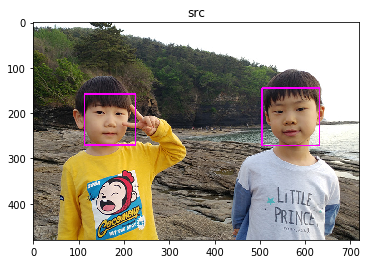

In [15]:
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow('src', src)    

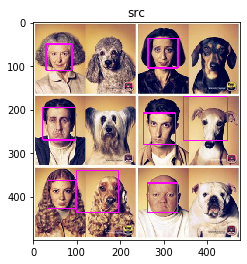

In [16]:
src = cv2.imread('./images/dog.jpg')
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow('src', src)   

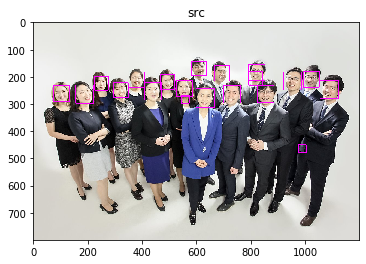

In [17]:
src = cv2.imread('./images/many.jpg')
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow('src', src)   

> 회전까지는 고려하지 못함.
- 보통 정면만 검출해도 +-10도까지는 검출함.
- 4방향을 모두 검출하려면 시간이 4배 소요됨.

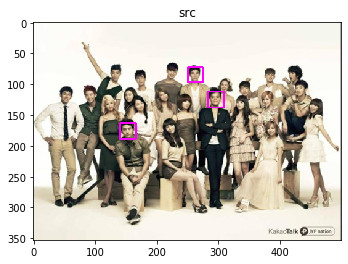

In [19]:
src = cv2.imread('./images/many2.jpg')
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow('src', src)   

# 눈 검출
> 검출할 때 
- 유사한 패턴, 유사성이 있어야 하는데

> 어려운 이유
- 얼굴만큼 패턴이 복잡하지 않음.-> 학습을 잘 시켜도 눈이 아닌 부분을 검출할 확률이 매우 높음.
- 고주파 성분이 별로 없음.


> 얼굴
- 패턴이 복잡한 편
- 얼굴 나름대로 공통된 패턴이 존재



## 1. haar + cascade 알고리즘

In [20]:
import cv2, numpy as np
import math
import time
import random
from matplotlib import pyplot as plt
%matplotlib inline
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

output_notebook()


Loading BokehJS ...

In [3]:
def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [4]:
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   

In [5]:
def update_win(frames) :
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, -1)
    myImage.data_source.data['image']=[fr]
    push_notebook()

In [8]:
classifier = cv2.CascadeClassifier('./lecture/haarcascade_eye.xml')

In [9]:
src = cv2.imread('images/kids.png')

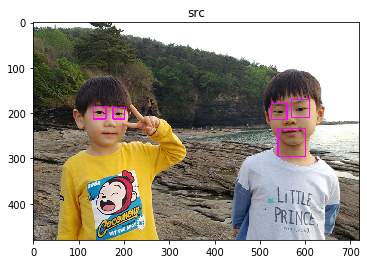

In [10]:
faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
imshow('src', src)    

- 얼굴이 검출된 부분에서만 눈을 찾아보기

In [21]:
face_classifier = cv2.CascadeClassifier('./lecture/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('./lecture/haarcascade_eye.xml')

src = cv2.imread('./images/kids.png')

faces = face_classifier.detectMultiScale(src)
faces

array([[113, 158, 112, 112],
       [504, 145, 126, 126]], dtype=int32)

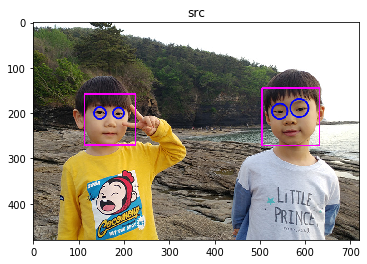

In [18]:
for (x1, y1, w1, h1) in faces:
        cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

        #얼굴 부분의 1/2에서만 검출
        faceROI = src[y1:y1 + h1, x1:x1 + w1]
        eyes = eye_classifier.detectMultiScale(faceROI)

        for (x2, y2, w2, h2) in eyes:
            center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
            cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)

imshow('src', src)  

> 눈을 감은 경우에는
- 눈이 검출되지 않음.

> 모자이크 효과
- 얼굴을 찾아서 작게 줄였다가 크게 늘리면  interpolation효과로 모자이크 효과가 나타남

# 3. 동영상에서 Harr 사용하기

In [63]:
cap = cv2.VideoCapture('images/lala.mp4')


In [64]:
classifier = cv2.CascadeClassifier('./lecture/haarcascade_frontalface_default.xml')

In [65]:
for i in range(600):
    # 비디오를 통째로 메모리에 넣지 않고 read할 때마다 하나씩 읽어들이기
    ret, frame = cap.read()
    # 호출할 때마다 창에 다음 frame을 갖고와서 보여줌
    if i == 0:
        create_win([frame])
    # 비디오가 끝나면 빠져나오게 하기
    if not ret:
        break
    faces = classifier.detectMultiScale(frame)

    for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)
    
    update_win([frame])